## imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage, compute_usage, assign_onsets
%matplotlib inline
import datetime

In [2]:
## for males

In [3]:
## upload data frame females
data_folder = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_08')
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_08/wheel_syllable_df_v00.parquet')
df = pd.read_parquet(path)

## get syllable maps from male ontogeny
df_temp = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_08/ontogeny_males_syllable_df_v00.parquet')
df_temp,usage_map = relabel_by_usage(df_temp, return_map=True)

df = assign_onsets(df)
df['relabeled_syllables'] = df['syllables'].map(usage_map)

In [4]:
# keep only sessions that belong to the wheel exp
df = df[df['session_name'].str.contains('wheel', case=False, na=False)]

In [5]:
sorted(df['subject_name'].unique())

['12c1_01_01',
 '12c1_01_02',
 '12c1_01_03',
 '12c1_01_04',
 '12c1_01_05',
 '12c1_01_06',
 '12c1_01_07',
 '12c1_01_08',
 '12c1_01_09',
 '12c1_01_10',
 '12c1_01_11',
 '12c1_01_12',
 '12c1_01_13',
 '12c1_01_14',
 '12c1_01_15',
 '12c1_01_16',
 '12c1_02_01',
 '12c1_02_02',
 '12c1_02_03',
 '12c1_02_04',
 '12c1_02_05',
 '12c1_02_06',
 '12c1_02_07',
 '12c1_02_11',
 '12c1_02_12',
 '12c1_02_13',
 '12c1_02_14',
 '12c1_02_15',
 '12c1_02_16',
 '12c1_03_01',
 '12c1_03_02',
 '12c1_03_03',
 '12c1_03_04',
 '12c1_03_05',
 '12c1_03_06',
 '12c1_03_07',
 '12c1_03_08',
 '12c1_03_09',
 '12c1_03_10',
 '12c1_03_11',
 '12c1_03_12',
 '12c1_03_13',
 '12c1_03_14',
 '12c1_03_15',
 '12c1_03_16',
 '12c1_04_01',
 '12c1_04_02',
 '12c1_04_03',
 '12c1_04_04',
 '12c1_04_05',
 '12c1_04_06',
 '12c1_04_07',
 '12c1_04_08',
 '12c1_04_11',
 '12c1_04_12',
 '12c1_04_13',
 '12c1_04_14',
 '12c1_04_15',
 '12c1_04_16',
 '12c2_01_01',
 '12c2_01_02',
 '12c2_01_03',
 '12c2_01_04',
 '12c2_01_05',
 '12c2_01_06',
 '12c2_01_07',
 '12c2_01_

In [6]:
# calcualte age in days
df.age = df.session_name.str[6:8]
#df.age = df.subject_name.str[:2]
df = df.astype({'age':'int'})
first= pd.Timestamp(year=2023, month=6, day=1)
age = (df.date-first).dt.days
df.age=df.age*7+age

In [7]:
sorted(df.age.unique())

[84,
 85,
 86,
 87,
 90,
 91,
 104,
 105,
 112,
 113,
 121,
 122,
 128,
 129,
 139,
 141,
 147,
 148,
 153,
 160,
 167,
 174,
 175,
 181,
 188,
 225,
 546,
 547,
 548,
 549,
 552,
 553,
 566,
 567,
 574,
 575,
 583,
 584,
 590,
 591,
 601,
 603,
 609,
 610,
 615,
 622,
 629,
 636,
 637,
 643,
 650,
 687]

## manual curations

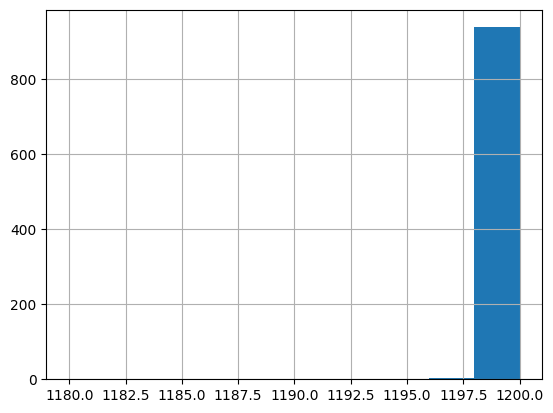

In [8]:
# clean up the data by removing short sessions
t = 600
session_length = df.groupby("uuid", sort=False)['timestamps'].max()
remove_uuids = session_length[session_length < t].index
session_length.hist()
df = df[~df['uuid'].isin(remove_uuids)]

In [9]:
# clean up the data by removing long sessions
t = 1250
session_length = df.groupby("uuid", sort=False)['timestamps'].max()
remove_uuids = session_length[session_length > t].index
df = df[~df['uuid'].isin(remove_uuids)]

<Axes: >

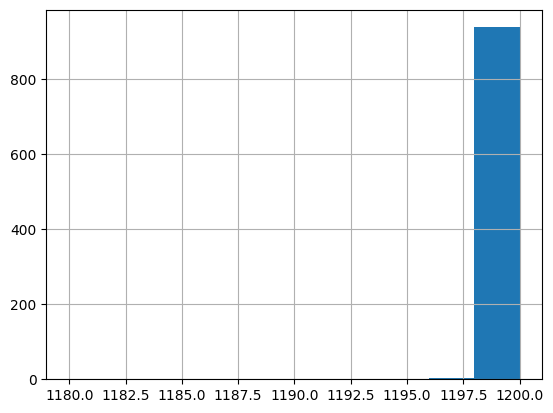

In [10]:
session_length = df.groupby("uuid", sort=False)['timestamps'].max()
session_length.hist()

## get mouse names

In [11]:
df['cage'] = df['subject_name'].str[:4]
df['mouse'] = df['subject_name'].str[:7]

In [12]:
len(sorted(df['mouse'].unique()))

64

In [13]:
# calculate usage
usage_df = df.query('onsets').groupby(['age','uuid','mouse','cage','subject_name','date'])['relabeled_syllables'].value_counts(normalize=True)
usage_df.name = 'usage'
usage_df = usage_df.reset_index()

In [14]:
## remove sessions were a syllable occours more than x% of time
thresh=0.2
syll_usage = usage_df.groupby("uuid", sort=False)['usage'].max()
remove_uuids=syll_usage[syll_usage>thresh].to_frame().reset_index()['uuid']
usage_df = usage_df[~usage_df['uuid'].isin(remove_uuids)]

In [15]:
#check number of sessions per age
temp = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age','uuid','subject_name','date']).fillna(0).reset_index()
counter = Counter(temp['age'])
counter

Counter({160: 32,
         167: 32,
         181: 32,
         188: 32,
         225: 32,
         622: 32,
         629: 32,
         643: 32,
         650: 32,
         687: 30,
         84: 16,
         85: 16,
         86: 16,
         87: 16,
         90: 16,
         91: 16,
         104: 16,
         105: 16,
         112: 16,
         113: 16,
         121: 16,
         128: 16,
         129: 16,
         153: 16,
         174: 16,
         175: 16,
         546: 16,
         547: 16,
         548: 16,
         549: 16,
         552: 16,
         553: 16,
         566: 16,
         567: 16,
         574: 16,
         575: 16,
         583: 16,
         584: 16,
         590: 16,
         591: 16,
         615: 16,
         636: 16,
         637: 16,
         122: 15,
         139: 12,
         141: 12,
         601: 12,
         603: 12,
         147: 9,
         148: 8,
         609: 8,
         610: 8})

## save dataframe

In [16]:
usage_mtx = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age', 'mouse','cage','uuid','subject_name','date']).fillna(0)
data_folder = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_08')
usage_mtx.to_parquet(data_folder / "wheel_clean.parquet", engine='pyarrow') 